In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [6]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

gender = Pipeline([
    ('selector', FeatureSelector(column='Gender')),
    ('ohe', OHEEncoder(key='Gender'))
])
gender.fit(X_train)
gender.transform(X_test).head(3)

,Gender_Female,Gender_Male
9394,1,0
898,1,0
2398,1,0


In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
set_config(display='diagram')

final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
        ('selector', FeatureSelector(column=cat_col)),
        ('ohe', OHEEncoder(key=cat_col))
    ])
    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
        ('selector', NumberSelector(key=cont_col)),
        ('standard', StandardScaler())
    ])
    final_transformers.append((cont_col, cont_transformer))

feature_processing = Pipeline([('feats', FeatureUnion(final_transformers))])
feature_processing

Pipeline(steps=[('feats',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Tenure'...
                                                                  StandardScaler())])),
                                                ('Balance',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))]))])

In [10]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve,    confusion_matrix

def print_sel_thresholds(y_test, preds):
    precision, recall, thresholds = precision_recall_curve(y_test, preds)

    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                            fscore[ix],
                                                                            precision[ix],
                                                                            recall[ix]))
    return thresholds[ix]

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [12]:
def confusion_matrix_create(y_test, preds, thresholds):
    font = {'size': 15}

    plt.rc('font', **font)

    cnf_matrix = confusion_matrix(y_test, preds > thresholds)
    plt.figure(figsize=(10, 8))
    plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                          title='Confusion matrix')
    plt.savefig("conf_matrix.png")
    plt.show()

In [13]:
models_results = {
    'approach': [],
    'F-Score': [],
    'Precision': [],
    'Recall': [],
}

In [14]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=13)

In [15]:
pipeline = Pipeline([
    ('features', feature_processing),
    ('classifier', model),
])

In [16]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 Pipeline(steps=[('feats',
                                  FeatureUnion(transformer_list=[('Geography',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Geography')),
                                                                                  ('ohe',
                                                                                   OHEEncoder(key='Geography'))])),
                                                                 ('Gender',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Gender')),
                                                                                  ('ohe',
                                                                                   OHEEncoder(key='Gender'))])),
                                                                 ('Tenure',
                                                                  Pipeline(steps=[('selector',
                                                                                   Fea...
                                                                                   NumberSelector(key='Balance')),
                                                                                  ('standard',
                                                                                   StandardScaler())])),
                                                                 ('NumOfProducts',
                                                                  Pipeline(steps=[('selector',
                                                                                   NumberSelector(key='NumOfProducts')),
                                                                                  ('standard',
                                                                                   StandardScaler())])),
                                                                 ('EstimatedSalary',
                                                                  Pipeline(steps=[('selector',
                                                                                   NumberSelector(key='EstimatedSalary')),
                                                                                  ('standard',
                                                                                   StandardScaler())]))]))])),
                ('classifier', RandomForestClassifier(random_state=13))])

In [17]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.3 , 0.19, 0.13, 0.02, 0.02, 0.76, 0.05, 0.13, 0.15, 0.68])

In [18]:
thresholds=print_sel_thresholds(y_test, preds)

Best Threshold=0.420000, F-Score=0.638, Precision=0.701, Recall=0.585


Confusion matrix, without normalization
[[1872  119]
 [ 219  290]]


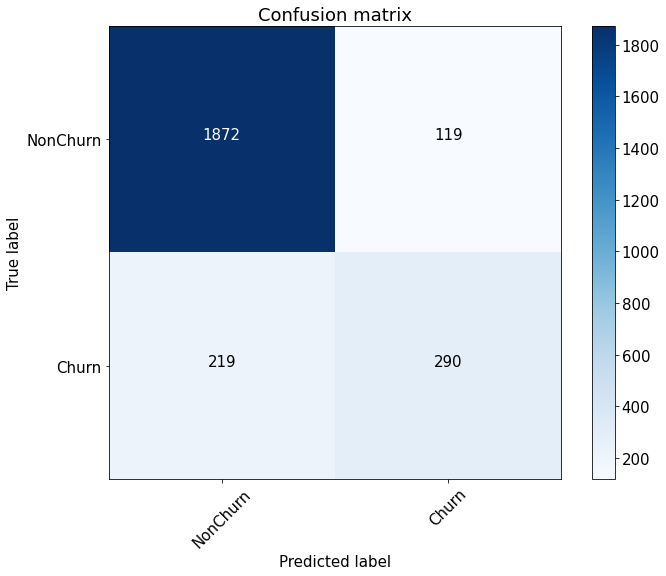

In [19]:
confusion_matrix_create(y_test, preds, thresholds)

In [20]:
models_results['approach'].append('RandomForestClassifier')
models_results['F-Score'].append(0.641)
models_results['Precision'].append(0.653)
models_results['Recall'].append(0.629)

In [21]:
model = LogisticRegression(random_state=13)

In [22]:
pipeline = Pipeline([
    ('features', feature_processing),
    ('classifier', model),
])

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 Pipeline(steps=[('feats',
                                  FeatureUnion(transformer_list=[('Geography',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Geography')),
                                                                                  ('ohe',
                                                                                   OHEEncoder(key='Geography'))])),
                                                                 ('Gender',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Gender')),
                                                                                  ('ohe',
                                                                                   OHEEncoder(key='Gender'))])),
                                                                 ('Tenure',
                                                                  Pipeline(steps=[('selector',
                                                                                   Fea...
                                                                                   NumberSelector(key='Balance')),
                                                                                  ('standard',
                                                                                   StandardScaler())])),
                                                                 ('NumOfProducts',
                                                                  Pipeline(steps=[('selector',
                                                                                   NumberSelector(key='NumOfProducts')),
                                                                                  ('standard',
                                                                                   StandardScaler())])),
                                                                 ('EstimatedSalary',
                                                                  Pipeline(steps=[('selector',
                                                                                   NumberSelector(key='EstimatedSalary')),
                                                                                  ('standard',
                                                                                   StandardScaler())]))]))])),
                ('classifier', LogisticRegression(random_state=13))])

In [24]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.22805865, 0.3350657 , 0.15347886, 0.12466446, 0.15507743,
       0.6431308 , 0.06214346, 0.077948  , 0.36717132, 0.76751542])

In [25]:
thresholds=print_sel_thresholds(y_test, preds)

Best Threshold=0.289522, F-Score=0.510, Precision=0.462, Recall=0.568


Confusion matrix, without normalization
[[1655  336]
 [ 221  288]]


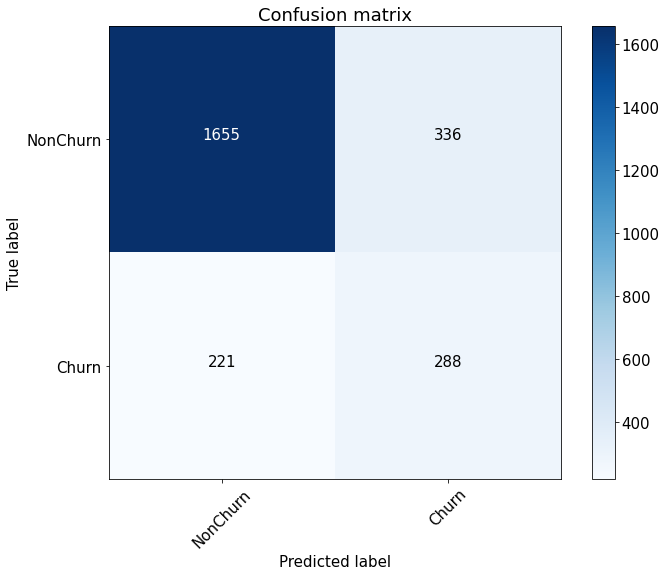

In [26]:
confusion_matrix_create(y_test, preds, thresholds)

In [27]:
models_results['approach'].append('LogisticRegression')
models_results['F-Score'].append(0.510)
models_results['Precision'].append(0.462)
models_results['Recall'].append(0.568)

In [28]:
from sklearn.ensemble import AdaBoostClassifier

model = AdaBoostClassifier(n_estimators=100)

In [29]:
pipeline = Pipeline([
    ('features', feature_processing),
    ('classifier', model),
])

In [30]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 Pipeline(steps=[('feats',
                                  FeatureUnion(transformer_list=[('Geography',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Geography')),
                                                                                  ('ohe',
                                                                                   OHEEncoder(key='Geography'))])),
                                                                 ('Gender',
                                                                  Pipeline(steps=[('selector',
                                                                                   FeatureSelector(column='Gender')),
                                                                                  ('ohe',
                                                                                   OHEEncoder(key='Gender'))])),
                                                                 ('Tenure',
                                                                  Pipeline(steps=[('selector',
                                                                                   Fea...
                                                                                   NumberSelector(key='Balance')),
                                                                                  ('standard',
                                                                                   StandardScaler())])),
                                                                 ('NumOfProducts',
                                                                  Pipeline(steps=[('selector',
                                                                                   NumberSelector(key='NumOfProducts')),
                                                                                  ('standard',
                                                                                   StandardScaler())])),
                                                                 ('EstimatedSalary',
                                                                  Pipeline(steps=[('selector',
                                                                                   NumberSelector(key='EstimatedSalary')),
                                                                                  ('standard',
                                                                                   StandardScaler())]))]))])),
                ('classifier', AdaBoostClassifier(n_estimators=100))])

In [31]:
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.49746813, 0.49831574, 0.49496487, 0.49474028, 0.49263549,
       0.49896141, 0.48945302, 0.48996406, 0.49979683, 0.49700692])

In [32]:
thresholds=print_sel_thresholds(y_test, preds)

Best Threshold=0.498955, F-Score=0.619, Precision=0.630, Recall=0.609


Confusion matrix, without normalization
[[1809  182]
 [ 200  309]]


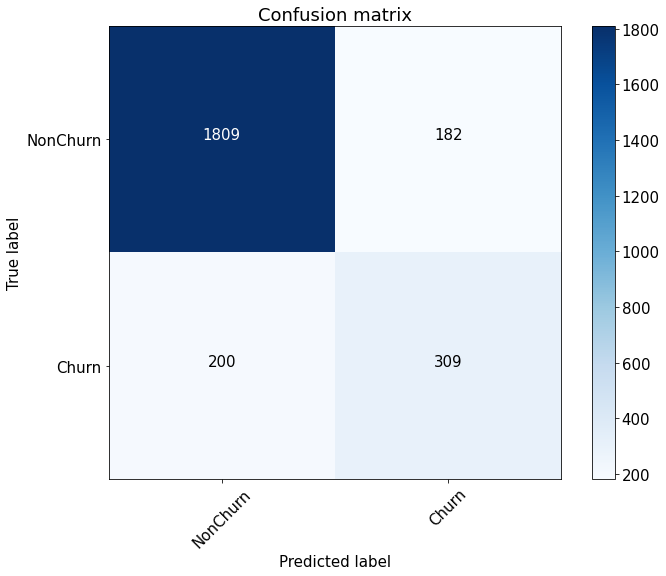

In [33]:
confusion_matrix_create(y_test, preds, thresholds)

In [34]:
models_results['approach'].append('AdaBoostClassifier')
models_results['F-Score'].append(0.619)
models_results['Precision'].append(0.630)
models_results['Recall'].append(0.609)

In [35]:
pd.DataFrame( models_results)

,approach,F-Score,Precision,Recall
0,RandomForestClassifier,0.641,0.653,0.629
1,LogisticRegression,0.510,0.462,0.568
2,AdaBoostClassifier,0.619,0.630,0.609


randomforestclassifier - лучше показала precision и recall, выбираем ее

In [36]:
cnf_matrix = confusion_matrix(y_test, preds>thresholds)

TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TN, FN, TP, FP

(1809, 200, 309, 182)

In [37]:
TP+FP

491

TP+FP удержание клиентов

In [38]:
2*TP

618

2*TP возврат средств 

In [39]:
2*TP-1*(TP+FP)

127

127 долларов доход